## Basic neural Network implementation using pytorch

In [31]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Enable reproducibility
torch.manual_seed(0)
#torch.set_deterministic(True)

# Create solution folder
Path("results/").mkdir(exist_ok=True)

## Data Preprocessing
### a) Dataset Loading

In [32]:
# Read CSV file
df = pd.read_csv("energy-weather.csv")



### b) Filtering

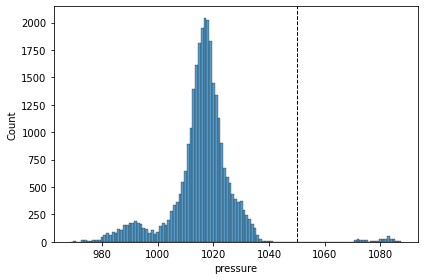

In [34]:
# Show histogram of pressure
sns.histplot(data=df["pressure"], discrete=True)
plt.axvline(1050, c="black", linestyle="dashed",linewidth=1)
plt.tight_layout()

In [35]:
# Remove outliers from the data set
df_filtered = df.drop(df.index[df["pressure"] > 1050 ])
df_filtered = df_filtered.drop(df_filtered.index[df_filtered["wind_speed"] > 30])


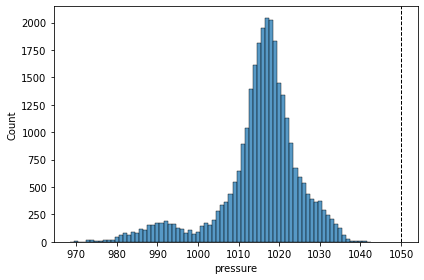

In [36]:
sns.histplot(data=df_filtered["pressure"], discrete=True)
plt.axvline(1050, c="black", linestyle="dashed",linewidth=1)
plt.tight_layout()

### c) Additional features

In [38]:
df_filtered.head()

,time,temperature,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,generation_solar
0,2015-01-01 00:00:00,270.475,1001,77,1,62,0.0,0,49.0
1,2015-01-01 01:00:00,270.475,1001,77,1,62,0.0,0,50.0
2,2015-01-01 02:00:00,269.686,1002,78,0,23,0.0,0,50.0
3,2015-01-01 03:00:00,269.686,1002,78,0,23,0.0,0,50.0
4,2015-01-01 04:00:00,269.686,1002,78,0,23,0.0,0,42.0


In [39]:
# Introduce day feature

df_filtered.loc[:, "day"] = pd.to_datetime(df_filtered["time"]).dt.dayofyear

#df_filtered.head()



# Introduce generation_solar_categorical feature
# df_filtered.loc[:, "generation_solar_categorical"] =



generation_solar_categorical = []

for i in df_filtered.generation_solar:
    if i < 160:
        generation_solar_categorical.append("low")
    elif i >= 160 and i < 1600:
        generation_solar_categorical.append("medium")
    elif i >= 1600:
        generation_solar_categorical.append("high")
df_filtered.loc[:, "generation_solar_categorical"] = generation_solar_categorical

df_filtered.tail()
         


,time,temperature,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,generation_solar,day,generation_solar_categorical
30041,2018-12-31 19:00:00,285.64,1028,62,2,140,0.0,0,85.0,365,low
30042,2018-12-31 20:00:00,283.14,1029,71,1,242,0.0,0,33.0,365,low
30043,2018-12-31 21:00:00,281.66,1029,81,3,300,0.0,0,31.0,365,low
30044,2018-12-31 22:00:00,280.14,1029,81,2,310,0.0,0,31.0,365,low
30045,2018-12-31 23:00:00,279.14,1029,75,2,300,0.0,0,31.0,365,low


### d) Normalize Data

In [41]:
# Standardize the dataset
from sklearn.preprocessing import StandardScaler

df_norm = df_filtered.loc[:,["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all","generation_solar", "day"]
    ]
 
scaler = StandardScaler()
df_1=pd.DataFrame(scaler.fit_transform(df_norm), columns=df_norm.columns)

req_col = ["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all","generation_solar", "day"]
req_df = df_filtered.copy()
req_df.loc[:, req_col] = df_1.values
req_df = req_df.reset_index(drop=True)
df_filtered = req_df
req_df.tail()



,time,temperature,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,generation_solar,day,generation_solar_categorical
29726,2018-12-31 19:00:00,-0.701683,1.260669,-0.160068,-0.287381,-0.168401,-0.131855,-0.813459,-0.798410,1.718137,low
29727,2018-12-31 20:00:00,-1.047515,1.359961,0.296755,-0.702910,0.680133,-0.131855,-0.813459,-0.829403,1.718137,low
29728,2018-12-31 21:00:00,-1.252247,1.359961,0.804335,0.128149,1.162633,-0.131855,-0.813459,-0.830595,1.718137,low
29729,2018-12-31 22:00:00,-1.462513,1.359961,0.804335,-0.287381,1.245822,-0.131855,-0.813459,-0.830595,1.718137,low
29730,2018-12-31 23:00:00,-1.600846,1.359961,0.499787,-0.287381,1.162633,-0.131855,-0.813459,-0.830595,1.718137,low


### e) Train/Validation split

In [43]:
# Train-validation split
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_filtered, test_size=0.1)
print(len(df_filtered))
print(len(df_train))
print(len(df_val))

29731
26757
2974


##  Modelling with PyTorch

In [45]:
# Build data loaders for PyTorch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]

x_train = torch.tensor(df_train[predictors].values,  dtype=torch.float)
x_val = torch.tensor(df_val[predictors].values,  dtype=torch.float)

y_train = torch.tensor(df_train[["generation_solar"]].values,  dtype=torch.float)
y_val = torch.tensor(df_val[["generation_solar"]].values,  dtype=torch.float)


y_train_cat = torch.tensor(pd.Series(df_train["generation_solar_categorical"], dtype="category").cat.codes.values.copy(),  dtype=torch.int64)
y_val_cat = torch.tensor(pd.Series(df_val["generation_solar_categorical"], dtype="category").cat.codes.values.copy(),  dtype=torch.int64)


# For regression
dataset = TensorDataset(x_train, y_train)

# For classification
dataset_cat = TensorDataset(x_train, y_train_cat)

### a) Build a network

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Create layers
        self.inp = nn.Linear(8, 10)
        self.hd1 = nn.Linear(10, 10)
        self.hd2 = nn.Linear(10,1)

    def forward(self, x):
        # Implement forward pass
        x = F.relu(self.inp(x))
        x = F.relu(self.hd1(x))
        x = self.hd2(x)
        
        return x

net = Net()

### b) Regression

  0%|          | 0/60 [00:00<?, ?it/s]

/home/mudit/.virtualenvs/py3/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


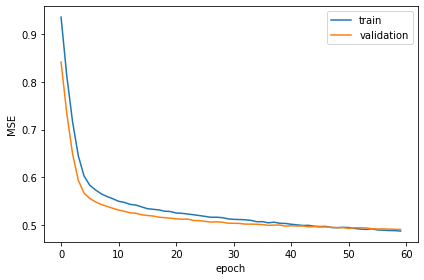

In [92]:
# Tune typerparameters 
# Hyperparameters
learn_rate = 0.5e-4
epochs = 60
batch_size = 256




class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Create layers
        self.inp = nn.Linear(8, 100)
        self.bn0 = nn.BatchNorm1d(100)
        self.hd0 = nn.Linear(100, 80)
        self.bn1 = nn.BatchNorm1d(80)
        self.hd1 = nn.Linear(80, 40)
        self.hd2 = nn.Linear(40, 10)        
        self.drp = nn.Dropout(0.2)
        self.hd3 = nn.Linear(10,1)

    def forward(self, x):
        # Implement forward pass
        x = F.leaky_relu(self.inp(x))        
        x = self.bn0(x)
        #x = self.drp(x)
        x = F.leaky_relu(self.hd0(x))
        x = self.bn1(x)
        x = F.leaky_relu(self.hd1(x))
        x = F.leaky_relu(self.hd2(x))
        x = self.hd3(x)
        
        return x
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.shape[0]
        losses.append([running_loss / len(dataset), criterion(net(x_val), y_val).item()])
        pbar.set_description(f"MSE {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3b.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("results/b3b.png")

### c) Classification

  0%|          | 0/60 [00:00<?, ?it/s]

/home/mudit/.virtualenvs/py3/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


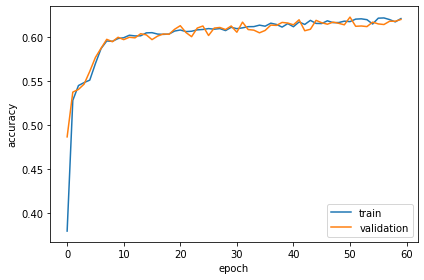

In [97]:
# Tune typerparameters 
# Hyperparameters
learn_rate = 1e-4
epochs = 60
batch_size = 256

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Create layers
        self.inp = nn.Linear(8, 100)
        self.bn0 = nn.BatchNorm1d(100)
        self.hd0 = nn.Linear(100, 80)
        self.bn1 = nn.BatchNorm1d(80)
        self.hd1 = nn.Linear(80, 40)
        self.hd2 = nn.Linear(40, 10)        
        self.drp = nn.Dropout(0.3)
        self.hd3 = nn.Linear(10,3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Implement forward pass
        x = F.leaky_relu(self.inp(x))        
        x = self.bn0(x)
        x = self.drp(x)
        x = F.leaky_relu(self.hd0(x))
        x = self.bn1(x)
        x = F.leaky_relu(self.hd1(x))
        x = F.leaky_relu(self.hd2(x))
        x = self.hd3(x)
        x = self.softmax(x)
        
        return x
net = Net()

net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader_cat = DataLoader(dataset_cat, batch_size=batch_size, shuffle=True)

losses=[]
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader_cat):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += torch.sum((torch.argmax(outputs, dim=1) == labels))  # changed 2021-01-08: Fixed accuracy computation
        losses.append([running_loss / len(dataset_cat), torch.sum((torch.argmax(net(x_val), dim=1) == y_val_cat)) / float(len(x_val))])  # changed 2021-01-08: Fixed accuracy computation
        
        pbar.set_description(f"Accuracy {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("results/b3c.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3c.png")